# Rétropropagation de l'erreur dans les réseaux de neurones à décharges
### GEI723, Automne 2024
Ce notebook présente comment l'algorithme de la descente du gradient peut être adapté pour la rétropropagation de l'erreur dans les réseaux de neurones à décharges avec des fonctions d'activation non dérivables.

Ce notebook est utilisé dans le cadre du cours GEI723 (Neuro-Computationnel).

- **Encodage de l'entrée** : Les entrées sont encodées sous forme de trains de spikes.
- **Structure du réseau** : Réseau de neurones à décharges avec plusieurs couches, utilisant différentes fonctions d'activation
- **Études menées** : 
  - Impact des fonctions d'activation et des dérivées sur la performance.
  - Analyse des méta-paramètres (nombre de couches, taux d'apprentissage, taille des lots).
  - Comparaison entre réseaux avec et sans apprentissage sur certaines couches.
- **Objectif du code** : Optimisation et analyse de la rétropropagation de l'erreur des réseaux de neurones à décharges.

**Auteurs :**
Clémence Lamballe
Behrouz Niknejad
Jean-Sébastien Giroux


### Sources :

Ce notebook a été inspiré du notebook créé par Ismaël Balafrej, Ph.D. avec Jean Rouat, Ph.D., ing., professeur et adapté par Ahmad El Ferdaoussi, Ph.D. et Arnaud Yarga, étud. Ph.D, dont le copyright et les auteurs sont:

Copyright (c) 2019-2024, Université de Sherbrooke, groupe de recherche NECOTIS. Tous droits réservés.  
Auteurs: Ismael Balafrej, Jean Rouat, adapté par Ahmad El Ferdaoussi et Arnaud Yarga


Ce travail a lui même été adapté et inspiré des articles suivants:
1. Surrogate Gradient Learning in Spiking Neural Networks by Zenke & Ganguli (2018) https://arxiv.org/pdf/1901.09948.pdf
2. SLAYER: Spike Layer Error Reassignment in Time (2018) https://arxiv.org/pdf/1810.08646.pdf
3. Biologically inspired alternatives to backpropagation through time for learning in recurrent neural nets (2019) https://arxiv.org/pdf/1901.09049.pdf


Dans cet exemple de code la gestion du potentiel et de l'intensité du neurone est placé dans la gestion des couches.
Vous pouvez décider de le faire autrement, par exemple dans la phase de propagation avant.

# Packages et imports

In [1]:
import enum
import numpy as np
import matplotlib.pyplot as plt
import quantities as units
import torch
from torch.autograd import Function
from sklearn import datasets, model_selection, utils
from sparse import COO
from SpikeFunctions import *

In [2]:
# Reproducibility
torch.manual_seed(0)
np.random.seed(0)

# Use the GPU unless there is none available.
# If you don't have a CUDA enabled GPU, I recommned using Google Colab,
# available at https://colab.research.google.com. Create a new notebook
# and then go to Runtime -> Change runtime type -> Hardware accelerator -> GPU
# Colab gives you access to up to 12 free continuous hours of a fairly recent GPU.
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)

cuda


In [3]:
import torch
print(torch.version.cuda)  # Should return the CUDA version, e.g., '11.8'
print(torch.cuda.is_available())

12.1
True


### Préparation des données

In [4]:
# Let's download the MNIST dataset, available at https://www.openml.org/d/554
# You can edit the argument data_home to the directory of your choice.
# The dataset will be downloaded there; the default directory is ~/scikit_learn_data/
X, y = datasets.fetch_openml('mnist_784', version=1, return_X_y=True, data_home=None, as_frame=False)
nb_of_samples, nb_of_features = X.shape
# X = 70k samples, 28*28 features; y = 70k samples, 1 label (string)

# Shuffle the dataset
X, y = utils.shuffle(X, y)


# Convert the labels (string) to integers for convenience
y = np.array(y, dtype=int)
nb_of_ouputs = np.max(y) + 1

# We'll normalize our input data in the range [0, 1[.
X = X / pow(2, 8)

### Conversion en décharges

In [5]:
# And convert the data to a spike train using TTFS encoding
# Choix utilisateur : dt
dt = 1*units.ms
duration_per_image = 100*units.ms
absolute_duration = int(duration_per_image / dt)

time_of_spike = (1 - X) * absolute_duration  # The brighter the pixel, the earlier the spike
time_of_spike[X < .25] = 0  # "Remove" the spikes associated with darker pixels, which presumably carry less information

sample_id, neuron_idx = np.nonzero(time_of_spike)

# We use a sparse COO array to store the spikes for memory requirements
# You can use the spike_train variable as if it were a tensor of shape (nb_of_samples, nb_of_features, absolute_duration)
spike_train = COO((sample_id, neuron_idx, time_of_spike[sample_id, neuron_idx].astype(int)),
                  np.ones_like(sample_id), shape=(nb_of_samples, nb_of_features, absolute_duration))



### Split entrainement/test/Validation

In [6]:
# Nombre total d'échantillons
print("nb_of_samples =", nb_of_samples)

# 80% pour l'entraînement
nb_of_train_samples = int(nb_of_samples * 0.80)

# 10% pour test
nb_of_test_samples = int(nb_of_samples * 0.10)

# 10% pour validation
nb_of_validation_samples = nb_of_samples - nb_of_train_samples - nb_of_test_samples

# Création des indices
train_indices = np.arange(nb_of_train_samples)
validation_indices = np.arange(nb_of_train_samples, nb_of_train_samples + nb_of_validation_samples)
test_indices = np.arange(nb_of_train_samples + nb_of_validation_samples, nb_of_samples)

print("train_indices.shape =", train_indices.shape)
print("validation_indices.shape =", validation_indices.shape)
print("test_indices.shape =", test_indices.shape)


total_samples = train_indices.shape[0] + test_indices.shape[0] + validation_indices.shape[0]
print(f"\nverification divisions bien faits: {total_samples==nb_of_samples}")


nb_of_samples = 70000
train_indices.shape = (56000,)
validation_indices.shape = (7000,)
test_indices.shape = (7000,)

verification divisions bien faits: True


### Création du réseau

In [8]:
# Choix utilisateur : nombre de couches cachées
nb_couches_cachees = 2  # Peut être 1, 2 ou 3

# Paramètres de chaque couche
nb_hidden1 = 128
nb_hidden2 = 64
nb_hidden3 = 32  # Utilisé uniquement si nb_couches_cachees = 3

# Initialisation des poids
w1 = torch.empty((nb_of_features, nb_hidden1), device=device, dtype=torch.float, requires_grad=True)
w1 = torch.nn.init.normal_(w1, mean=0., std=.1)

if nb_couches_cachees >= 2:
    w_hidden2 = torch.empty((nb_hidden1, nb_hidden2), device=device, dtype=torch.float, requires_grad=True)
    torch.nn.init.normal_(w_hidden2, mean=0., std=.1)

if nb_couches_cachees == 3:
    w_hidden3 = torch.empty((nb_hidden2, nb_hidden3), device=device, dtype=torch.float, requires_grad=True)
    torch.nn.init.normal_(w_hidden3, mean=0., std=.1)
    w2 = torch.empty((nb_hidden3, nb_of_ouputs), device=device, dtype=torch.float, requires_grad=True)
else:
    w2 = torch.empty((nb_hidden2 if nb_couches_cachees == 2 else nb_hidden1, nb_of_ouputs), device=device, dtype=torch.float, requires_grad=True)

w2 = torch.nn.init.normal_(w2, mean=0., std=.1)


In [9]:
# # We create a 2 layer network (1 hidden, 1 output)
# # choix utilisateur : nombre de neurones par couche

nb_hidden = 128  # Number of hidden neurons

# # choix utilisateur : nombre de couches
# nb_hidden1 = 128  # Nombre de neurones de la première couche cachée
# nb_hidden2 = 64   # Nombre de neurones de la deuxième couche cachée

# # Poids pour la première couche cachée

# w1 = torch.empty((nb_of_features, nb_hidden1), device=device, dtype=torch.float, requires_grad=True)
# torch.nn.init.normal_(w1, mean=0., std=.1)
# #torch.nn.init.normal_(w1, mean=1., std=.1)

# # Poids pour la deuxième couche cachée

# w_hidden2 = torch.empty((nb_hidden1, nb_hidden2), device=device, dtype=torch.float, requires_grad=True)
# torch.nn.init.normal_(w_hidden2, mean=0., std=.1)

# # Poids pour la couche de sortie

# #w2 = torch.empty((nb_hidden1, nb_of_ouputs), device=device, dtype=torch.float, requires_grad=True)
# w2 = torch.empty((nb_hidden2, nb_of_ouputs), device=device, dtype=torch.float, requires_grad=True)
# torch.nn.init.normal_(w2, mean=0., std=.1)
# #torch.nn.init.normal_(w2, mean=1., std=.1)




# 1) Préparation de la configuration pour le réseau de neurones

<h3 style="background-color: yellow; color: darkblue; display: inline-block; padding: 0.3em;">Choix Utilisateur</h3>


In [10]:
# Valeurs à modifier par l'utilisateur
selected_function = 7  # Choix de la fonction d'activation 
#1 = ReLU classique, 2 = Leaky ReLU, 3 = Abs ReLU, 4 = Heaviside et dérivée ReLU classique, 5 = Sigmoïde, 6 = Triangulaire, 7 = Gaussienne
params_sigmoid = {"alpha": 2} #Valeurs testées :  0.5, 1.0, 2
params_triangular = {"theta": 0, "delta": 1}# Valeurs testées :(0, 1), (0, 2), (1, 1), (-1, 1)
params_gaussian = {"alpha": 1.0, "theta": -1.0}# Valeurs testées :(1.0, 0.0), (3, 0.0),(0.5, 0.0), (1.0, 1.0), (1.0, -1.0)
#


# Conversion des choix en énumérations
#selected_method_enum = Methodes_Apprentissage(selected_method)
selected_function_enum = Fonctions_Activation(selected_function)

Functions_parameters = None

if selected_function_enum == Fonctions_Activation.SpikeFunction_Sigmoid:
    Functions_parameters = params_sigmoid
elif selected_function_enum == Fonctions_Activation.SpikeFunction_Triangular:
    Functions_parameters = params_triangular
elif selected_function_enum == Fonctions_Activation.SpikeFunction_Gaussian:
    Functions_parameters = params_gaussian
else:
    Functions_parameters = {}  # Pas de paramètres spécifiques pour les autres fonctions


# Création de la couche avec les paramètres spécifiques (si nécessaires)
Layer = CustomActivation(activation_func=activation_func)

# Affichage de la fonction et des paramètres sélectionnés
print(f"Nom de la fonction d'activation : {activation_func.name}")


Nom de la fonction d'activation : SpikeFunction_Gaussian
Paramètres associés : {'alpha': 1.0, 'theta': -1.0}


### Implémentation dynamique LIF 


In [11]:
def run_spiking_layer(input_spike_train, layer_weights, tau_v=20*units.ms, tau_i=5*units.ms, v_threshold=1.0):
    """Here we implement a current-LIF dynamic in PyTorch"""

    # First, we multiply the input spike train by the weights of the current layer to get the current that will be added
    # We can calculate this beforehand because the weights are constant in the forward pass (no plasticity)
    input_current = torch.einsum("abc,bd->adc", (input_spike_train, layer_weights))  # Equivalent to a matrix multiplication for tensors of dim > 2 using Einstein's Notation

    recorded_spikes = []  # Array of the output spikes at each time t
    membrane_potential_at_t = torch.zeros((input_spike_train.shape[0], layer_weights.shape[-1]), device=device, dtype=torch.float)
    membrane_current_at_t = torch.zeros((input_spike_train.shape[0], layer_weights.shape[-1]), device=device, dtype=torch.float)

    for t in range(absolute_duration):  # For every timestep
        # Apply the leak
        #TODO CHANGER LES EQUATIONS ICI CEST LAID
        membrane_potential_at_t = float(np.exp(-dt/tau_v))*membrane_potential_at_t # Using tau_v with euler or exact method
        membrane_current_at_t = float(np.exp(-dt/tau_i))*membrane_current_at_t # Using tau_i with euler or exact method

        # Select the input current at time t
        input_at_t = input_current[:, :, t]

        # Integrate the input current
        membrane_current_at_t += input_at_t

        # Integrate the input to the membrane potential

        membrane_potential_at_t += membrane_current_at_t *float(dt/tau_v) #! *float(dt/tau_v)??
        

        # Apply the non-differentiable function
        if Layer.activation_class.name != 'SpikeFunction_Default':
            recorded_spikes_at_t = Layer(membrane_potential_at_t - v_threshold)
        else:
            recorded_spikes_at_t = SpikeFunction_Default.apply(membrane_potential_at_t - v_threshold)
     

        
        recorded_spikes.append(recorded_spikes_at_t)

        # Reset the spiked neurons
        membrane_potential_at_t[membrane_potential_at_t > v_threshold] = 0

    recorded_spikes = torch.stack(recorded_spikes, dim=2) # Stack over time axis (Array -> Tensor)
    return recorded_spikes


# 2) Entrainement et Validation

In [12]:
print(f"Fonction sélectionnée : {Function_name}")
if Functions_parameters is None:
    print("Paramètres associés : Paramètres initiaux")
else:
    print("Paramètres associés :", ", ".join(f"{key}: {value}" for key, value in Functions_parameters.items()))
print(f"Nb couches cachées : {nb_couches_cachees}")

    
# Set-up training
correct_label_count = 0

# Choix utilisateur : nombre d'époques et la taille des lots
nb_of_epochs = 20
batch_size = 256  # The backpropagation is done after every batch, but a batch here is also used for memory requirements
number_of_batches = len(train_indices) // batch_size

#params = [w1,w2]  # Trainable parameters
#params = [w1, w_hidden2,w2]  # Trainable parameters
# Liste des paramètres à entraîner
params = [w1, w2]
if nb_couches_cachees >= 2:
    params.insert(1, w_hidden2)
if nb_couches_cachees == 3:
    params.insert(2, w_hidden3)

# Choix utilisateur : taux d'apprentissage lr
optimizer = torch.optim.Adam(params, lr=0.01, amsgrad=True)
loss_fn = torch.nn.MSELoss(reduction='mean')

# Initialisation des listes pour stocker les poids
w1_history = []
w_hidden2_history= []
w2_history = []

loss_history = {}
loss_history[Function_name] = []


for e in range(nb_of_epochs):
    epoch_loss = 0
    for batch in np.array_split(train_indices, number_of_batches):
        # Select batch and convert to tensors
        batch_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)
        batch_labels = torch.LongTensor(y[batch, np.newaxis]).to(device)

        # Here we create a target spike count (10 spikes for wrong label, 100 spikes for true label) in a one-hot fashion
        # This approach is seen in Shrestha & Orchard (2018) https://arxiv.org/pdf/1810.08646.pdf
        # Code available at https://github.com/bamsumit/slayerPytorch
        min_spike_count = 10 * torch.ones((batch.shape[0], 10), device=device, dtype=torch.float)
        target_output = min_spike_count.scatter_(1, batch_labels, 100.0)

        # Forward propagation

        # 1 couches cahée

        #layer_1_spikes = run_spiking_layer(batch_spike_train, w1)
        #layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
        #network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis

        # 2 couches cahées

        # Passe avant avec sommation temporelle
        #layer_1_spikes = run_spiking_layer(batch_spike_train, w1)  # Première couche cachée
        #layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)  # Deuxième couche cachée
        #output_spikes = run_spiking_layer(layer_2_spikes, w2)  # Couche de sortie
        #network_output = torch.sum(output_spikes, 2)  # Sommation sur l'axe temporel

        #loss = loss_fn(network_output, target_output)

        # Forward propagation
        layer_1_spikes = run_spiking_layer(batch_spike_train, w1)
        if nb_couches_cachees == 1:
            output_spikes = run_spiking_layer(layer_1_spikes, w2)
        elif nb_couches_cachees == 2:
            layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)
            output_spikes = run_spiking_layer(layer_2_spikes, w2)
        else:  # nb_couches_cachees == 3
            layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)
            layer_3_spikes = run_spiking_layer(layer_2_spikes, w_hidden3)
            output_spikes = run_spiking_layer(layer_3_spikes, w2)

        network_output = torch.sum(output_spikes, 2)  # Sommation temporelle
        loss = loss_fn(network_output, target_output)


        # Backward propagation
        optimizer.zero_grad()
        loss.backward()
        

        optimizer.step()
        epoch_loss += loss.item()

    #print("\nW1: ",w1.grad)  # Pour vérifier les gradients de w1
    #print("W2: ",w2.grad)  # Pour vérifier les gradients de w2   
    #VALIDATION
    
    with torch.no_grad():
        for batch in np.array_split(validation_indices,  len(validation_indices) // batch_size):

            validation_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)

            # Same forward propagation as before
            # 1 couche cachée
            #layer_1_spikes = run_spiking_layer(validation_spike_train, w1)
            #layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
            #network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis

            # 2 couches cachées
            #layer_1_spikes = run_spiking_layer(validation_spike_train, w1)
            #layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)
            #output_spikes = run_spiking_layer(layer_2_spikes, w2)
            #network_output = torch.sum(output_spikes, 2)  # Sommation sur l'axe temporel
            layer_1_spikes = run_spiking_layer(validation_spike_train, w1)
            if nb_couches_cachees == 1:
                output_spikes = run_spiking_layer(layer_1_spikes, w2)
            elif nb_couches_cachees == 2:
                layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)
                output_spikes = run_spiking_layer(layer_2_spikes, w2)
            else:  # nb_couches_cachees == 3
                layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)
                layer_3_spikes = run_spiking_layer(layer_2_spikes, w_hidden3)
                output_spikes = run_spiking_layer(layer_3_spikes, w2)
            network_output = torch.sum(output_spikes, 2)



            #print("network_output shape:", network_output.shape)  # Affiche la forme de la sortie
            #print("y[batch] shape:", y[batch].shape)  # Affiche la forme des labels


            # Do the prediction by selecting the output neuron with the most number of spikes
            _, am = torch.max(network_output, 1)
            #print(f"Prédictions : {am.cpu().numpy()}")  # Affiche les prédictions #! QUE DES 0!!!!!!!!
            #print(f"Labels réels : {y[batch]}")  # Affiche les labels réels
            correct_label_count += np.sum(am.detach().cpu().numpy() == y[batch])

        

    print("\nEpoch %i -- loss : %.4f" %(e+1, epoch_loss / number_of_batches))
    avg_epoch_loss = epoch_loss / number_of_batches
    loss_history[Function_name].append(avg_epoch_loss)
    
    # Affichage des 1er, 2e et dernier poids de w1 et w2
    print(f"Weight evolution - w1: First = {w1.detach().cpu().numpy()[0][0]}, "
      f"Second = {w1.detach().cpu().numpy()[1][0]}, "
      f"Last = {w1.detach().cpu().numpy()[-1][0]}, "
      f"Weight at (12, 25) = {w1.detach().cpu().numpy()[12][25]}")

    #print(f"Weight evolution - w1: First = {w1.detach().cpu().numpy()[0][0]}, Second = {w1.detach().cpu().numpy()[1][0]}, Last = {w1.detach().cpu().numpy()[-1][0]}")
    if nb_couches_cachees >= 2:
        print(f"Weight evolution - w_hidden2: First = {w_hidden2.detach().cpu().numpy()[0][0]}, Second = {w_hidden2.detach().cpu().numpy()[1][0]}, Last = {w_hidden2.detach().cpu().numpy()[-1][0]}, Weight at (12, 25) = {w_hidden2.detach().cpu().numpy()[12][25]}")
        w_hidden2_history.append(w_hidden2.detach().cpu().numpy().copy())

    print(f"Weight evolution - w2: First = {w2.detach().cpu().numpy()[0][0]}, Second = {w2.detach().cpu().numpy()[1][0]}, Last = {w2.detach().cpu().numpy()[-1][0]}")
    w1_history.append(w1.detach().cpu().numpy().copy())  
    w2_history.append(w2.detach().cpu().numpy().copy())

print("VALIDATION : Model accuracy on test set: %.3f" % (correct_label_count / len(validation_indices)))



Fonction sélectionnée : SpikeFunction_Gaussian
Paramètres associés : alpha: 1.0, theta: -1.0
Nb couches cachées : 2

Epoch 1 -- loss : 957.0771
Weight evolution - w1: First = -0.11258398741483688, Second = -0.08833757787942886, Last = -0.02453634701669216, Weight at (12, 25) = -0.02140194922685623
Weight evolution - w_hidden2: First = -0.032661255449056625, Second = -0.0008380409562960267, Last = 0.07316138595342636, Weight at (12, 25) = 0.1258569210767746
Weight evolution - w2: First = 0.17815491557121277, Second = 0.18903376162052155, Last = 0.08815176784992218

Epoch 2 -- loss : 495.1461
Weight evolution - w1: First = -0.11258398741483688, Second = -0.08833757787942886, Last = -0.02453634701669216, Weight at (12, 25) = -0.09805737435817719
Weight evolution - w_hidden2: First = -0.0328608900308609, Second = -0.0009244286338798702, Last = 0.07307867705821991, Weight at (12, 25) = 0.10211390256881714
Weight evolution - w2: First = 0.17884118854999542, Second = 0.18764710426330566, Last

# 3) Test

In [13]:
print(f"Fonction sélectionnée : {Function_name}")
if Functions_parameters is None:
    print("Paramètres associés : Paramètres initiaux")
else:
    print("Paramètres associés :", ", ".join(f"{key}: {value}" for key, value in Functions_parameters.items()))
print(f"Nb couches cachées : {nb_couches_cachees}")


# Test the accuracy of the model
correct_label_count = 0

# We only need to batchify the test set for memory requirements
for batch in np.array_split(test_indices,  len(test_indices) // batch_size):
    test_spike_train = torch.FloatTensor(spike_train[batch].todense()).to(device)

    # Same forward propagation as before
    #layer_1_spikes = run_spiking_layer(test_spike_train, w1)
    #layer_2_spikes = run_spiking_layer(layer_1_spikes, w2)
    #network_output = torch.sum(layer_2_spikes, 2)  # Count the spikes over time axis
    layer_1_spikes = run_spiking_layer(test_spike_train, w1)
    if nb_couches_cachees == 1:
        output_spikes = run_spiking_layer(layer_1_spikes, w2)
    elif nb_couches_cachees == 2:
        layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)
        output_spikes = run_spiking_layer(layer_2_spikes, w2)
    else:  # nb_couches_cachees == 3
        layer_2_spikes = run_spiking_layer(layer_1_spikes, w_hidden2)
        layer_3_spikes = run_spiking_layer(layer_2_spikes, w_hidden3)
        output_spikes = run_spiking_layer(layer_3_spikes, w2)

    network_output = torch.sum(output_spikes, 2)  # Count the spikes over time axis

    

    # Do the prediction by selecting the output neuron with the most number of spikes
    _, am = torch.max(network_output, 1)
    correct_label_count += np.sum(am.detach().cpu().numpy() == y[batch])

print("Model accuracy on test set: %.3f" % (correct_label_count / len(test_indices)))

Fonction sélectionnée : SpikeFunction_Gaussian
Paramètres associés : alpha: 1.0, theta: -1.0
Nb couches cachées : 2
Model accuracy on test set: 0.954


# 4) Graphiques

### Évolution des poids

In [14]:
w1_changes = []
def analyze_weight_changes(weight_history, layer_name):
    """
    Analyse les changements de poids dans une couche donnée.
    
    Arguments:
    - weight_history : historique des poids (numpy array)
    - layer_name : nom de la couche pour l'affichage des résultats
    
    Retourne :
    - Nombre total de poids
    - Nombre de poids ayant changé
    - Pourcentage de poids modifiés
    - Pourcentage de poids non modifiés
    """
    weight_history = np.array(weight_history)
    changes = []  # Liste des indices où les poids changent
    
    for i in range(weight_history.shape[1]):
        for j in range(weight_history.shape[2]):
            if weight_history[-1, i, j] != weight_history[0, i, j]:
                changes.append((i, j))
    if layer_name == "w1":
        w1_changes = changes
    # Résultats
    total_weights = weight_history.shape[1] * weight_history.shape[2]
    changed_weights = len(changes)
    percentage_changed = (changed_weights / total_weights) * 100
    percentage_not_changed = 100 - percentage_changed
    
    # Affichage
    #if changes:
        #print(f"Indices des poids de {layer_name} ayant changé : {changes}")
    #else:
        #print(f"Les poids de {layer_name} n'ont pas changé.")
    
    #print(f"\nNombre total de poids dans {layer_name} : {total_weights}")
    #print(f"Nombre de poids ayant changé dans {layer_name} : {changed_weights}")
    #print(f"Pourcentage de poids ayant changé dans {layer_name} : {percentage_changed:.2f}%")
    print(f"Pourcentage de poids n'ayant pas changé dans {layer_name} : {percentage_not_changed:.2f}%")
    
    return total_weights, changed_weights, percentage_changed, percentage_not_changed

# Analyse des couches
total_w1, changed_w1, _, _ = analyze_weight_changes(w1_history, "w1")
total_hidden2, changed_hidden2, _, _ = analyze_weight_changes(w_hidden2_history, "w_hidden2")
total_w2, changed_w2, _, _ = analyze_weight_changes(w2_history, "w2")

# Calcul global
total_weights_all = total_w1 + total_hidden2 + total_w2
changed_weights_all = changed_w1 + changed_hidden2 + changed_w2
percentage_changed_all = (changed_weights_all / total_weights_all) * 100
percentage_not_changed_all = 100 - percentage_changed_all

print(f"\nPourcentage de poids ayant changé au total : {percentage_changed_all:.2f}%")
print(f"Pourcentage de poids n'ayant pas changé au total : {percentage_not_changed_all:.2f}%")


Pourcentage de poids n'ayant pas changé dans w1 : 11.99%
Pourcentage de poids n'ayant pas changé dans w_hidden2 : 0.00%
Pourcentage de poids n'ayant pas changé dans w2 : 0.00%

Pourcentage de poids ayant changé au total : 88.98%
Pourcentage de poids n'ayant pas changé au total : 11.02%


test

Fonction sélectionnée : SpikeFunction_Gaussian
Fonction sélectionnée : alpha: 1.0 , theta: -1.0
Fonction sélectionnée : SpikeFunction_Gaussian
Paramètres : alpha: 1.0 , theta: -1.0


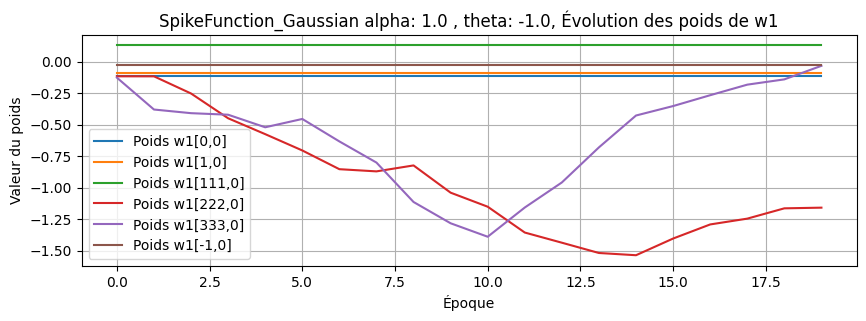

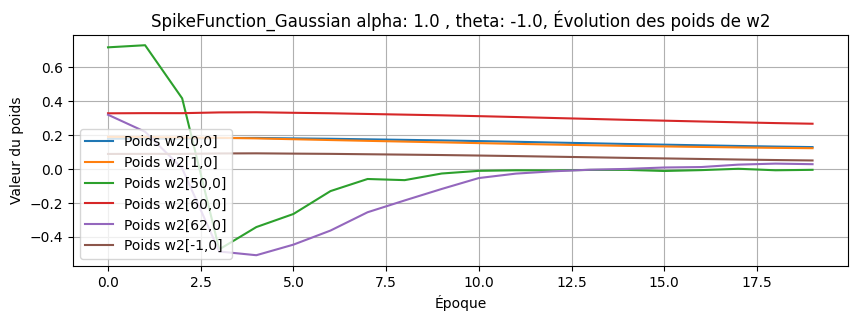

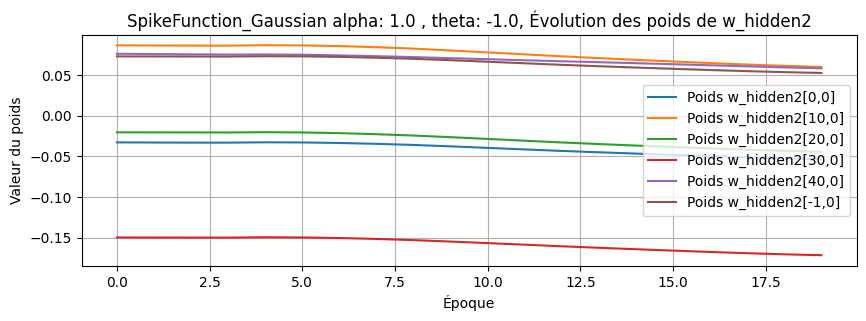

In [15]:
print(f"Fonction sélectionnée : {Function_name}")

if Functions_parameters is None:
    params_description= "avec aramètres initiaux"
else:
    params_description = " , ".join(f"{key}: {value}" for key, value in Functions_parameters.items())
# Convertir w1_history et w2_history en tableaux numpy pour faciliter les manipulations
print(f"Fonction sélectionnée : {params_description}")


def plot_weight_evolution(weight_history, indices_to_plot, layer_name, Function_name, params_description):
    """
    Trace l'évolution des poids pour une couche spécifique.
    
    Arguments :
    - weight_history : historique des poids (numpy array)
    - indices_to_plot : indices des poids à tracer
    - layer_name : nom de la couche (ex : w1, w2, w_hidden2)
    - Function_name : nom de la fonction utilisée
    - params_description : description des paramètres de la fonction
    """
    plt.figure(figsize=(10, 3))
    
    for i, idx in enumerate(indices_to_plot):
        weight = weight_history[:, idx, 0]  # Poids pour le premier neurone cible
        label = f"Poids {layer_name}[{idx},0]"
        plt.plot(weight, label=label)
    
    plt.title(f"{Function_name} {params_description}, Évolution des poids de {layer_name}")
    plt.xlabel("Époque")
    plt.ylabel("Valeur du poids")
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

# Préparer les données
w1_history = np.array(w1_history)
w2_history = np.array(w2_history)
w_hidden2_history = np.array(w_hidden2_history)  # Ajouter pour w_hidden2
additional_indices = []
additional_indices = w1_changes[:2]

# Définir les indices des poids à tracer
indices_w1 = [0, 1, 111, 222, 333, -1] + [idx[0] for idx in additional_indices]
indices_w2 = [0, 1, 50, 60, 62, -1]
indices_hidden2 = [0, 10, 20, 30, 40, -1]  # Ajouter des indices pour w_hidden2 si nécessaire

# Afficher les graphiques
print(f"Fonction sélectionnée : {Function_name}")
print(f"Paramètres : {params_description}")

# Tracer les poids pour chaque couche
plot_weight_evolution(w1_history, indices_w1, "w1", Function_name, params_description)
plot_weight_evolution(w2_history, indices_w2, "w2", Function_name, params_description)
plot_weight_evolution(w_hidden2_history, indices_hidden2, "w_hidden2", Function_name, params_description)


### Évolution du loss 

SpikeFunction_Gaussian alpha: 1.0 , theta: -1.0 : 957.077, 495.146, 447.013, 403.043, 343.509, 286.679, 262.973, 230.080, 209.913, 190.851, 178.271, 165.419, 152.320, 143.947, 135.187, 134.083, 127.439, 122.547, 118.442, 115.152


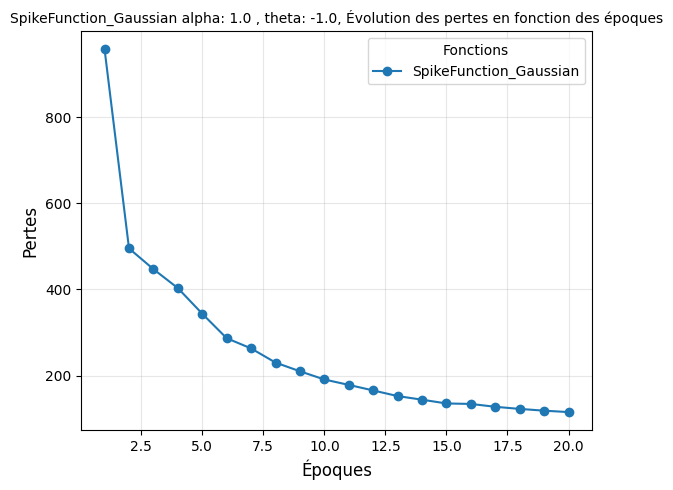

In [16]:

# Exemple de dictionnaire contenant les pertes pour chaque fonction


# Tracé des courbes
plt.figure(figsize=(6, 5))
for function_name, losses in loss_history.items():
    epochs = range(1, len(losses) + 1)  # Crée un range d'époques correspondant à chaque liste de pertes
    plt.plot(epochs, losses, marker='o', label=function_name)
    print(f"{function_name} {params_description} : {', '.join([f'{loss:.3f}' for loss in losses])}")


# Personnalisation du graphique
plt.title(f"{Function_name} {params_description}, Évolution des pertes en fonction des époques", fontsize=10)
plt.xlabel("Époques", fontsize=12)
plt.ylabel("Pertes", fontsize=12)
plt.legend(title="Fonctions", fontsize=10)
plt.grid(alpha=0.3)

# Affichage
plt.tight_layout()
plt.show()
